# Group 27 Project Proposal

**Team Members** Khushi Narang, Mengen Liu, Rosha Mehrad, Yilin Long   

## Libraries

In [1]:
library(tidymodels)
library(tidyverse)
library(repr)
library(httr)
library(readxl)
library(ggplot2)
library(GGally)

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ recipes      1.0.1
✔ dials        1.0.0     ✔ rsample      1.0.0
✔ dplyr        1.0.9     ✔ tibble       3.1.7
✔ ggplot2      3.3.6     ✔ tidyr        1.2.0
✔ infer        1.0.2     ✔ tune         1.0.0
✔ modeldata    1.0.0     ✔ workflows    1.0.0
✔ parsnip      1.0.0     ✔ workflowsets 1.0.0
✔ purrr        0.3.4     ✔ yardstick    1.0.0

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Use suppressPackageStartupMessages() to eliminate package startup messages

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ readr   2.1.2     ✔ forcats 0.5.1
✔ stringr 1.4.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr:

## Introduction

Question we would like to answer:

**Can pulsar radio emissions be accurately differentiated from radio frequency interference (RFI) and radio noise?**

Pulsars, which are neutron stars, are a rare phenomenon that can emit radio signals that are detectable on Earth. These stars are highly valuable for scientific research, as they can provide insight into space-time, the interstellar medium, and states of matter (see [2] for more uses).

<img src='https://media.giphy.com/media/l3dj5M4YLaFww31V6/giphy.gif' width='400'>

Source: https://media.giphy.com/media/l3dj5M4YLaFww31V6/giphy.gif


Although each pulsar emits a slightly different pattern of radio signals that varies with each rotation, potential signals, known as 'candidates', are averaged over multiple rotations during observation. Without additional information, each candidate has the potential to represent a real pulsar. However, the vast majority of detections are caused by radio frequency interference (RFI) and noise, making it difficult to differentiate legitimate signals from false positives. 

HTRU2 [1] is the data set we used here. It is a data set which describes a sample of pulsar candidates collected during the High Time Resolution Universe Survey (South). It contains both spurious and real pulsar examples. The question we will solve in this project is “Can pulsar radio emissions be accurately differentiated from radio frequency interference (RFI) and radio noise?” For this we need to analyse statistical and observational data we have on the signals (we refer to them as candidates in many places).

The image below shows what each column in the data set stands for.

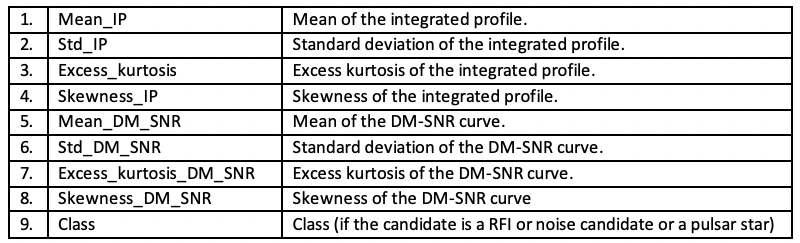

## Preliminary exploratory data analysis

**Reading the Data from the web**

In [2]:
# read the dataset
# Downloaded the zipped Pulsar data from URL
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
GET(URL, write_disk(tf <- tempfile(fileext = ".zip")))

# Unzip the tempfile and read the csv inside it
pulsar_data <- read_csv(unz(tf, "HTRU_2.csv"), col_names=FALSE)

Response [https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip]
  Date: 2023-03-12 05:50
  Status: 200
  Content-Type: application/x-httpd-php
  Size: 1.56 MB
<ON DISK>  /tmp/RtmpBWaxIH/file3c383bcbe3.zipNULL

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


**Cleaning and wrangling the data into a tidy format**

We observed that column names were not present in the dataset. Therefore, we first wrangled the data by adding the columns names and write to modify the csv file. Also, the class column used 0 to represent RFI noise and 1 to represent pulsar. We also mutated the target class to be more meaningful value for a human. 

In [3]:
# add column names using rename
pulsar_data_tidy <- rename(pulsar_data, Mean_IP=X1,Std_IP=X2, Excess_kurtosis_IP=X3, Skewness_IP=X4,
                     Mean_DM_SNR=X5, Std_DM_SNR=X6, Excess_kurtosis_DM_SNR=X7, Skewness_DM_SNR=X8, Class=X9)|>

# mutate the class to a more meaningful value for a human instead of 0 and 1
               mutate(Class = as_factor(case_when(Class == 1 ~ "pulsar",
                                                TRUE ~ "rfi_noise")))

head(pulsar_data_tidy)

Mean_IP,Std_IP,Excess_kurtosis_IP,Skewness_IP,Mean_DM_SNR,Std_DM_SNR,Excess_kurtosis_DM_SNR,Skewness_DM_SNR,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,rfi_noise
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,rfi_noise
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,rfi_noise
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,rfi_noise
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,rfi_noise
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,rfi_noise


**Splitting into training and testing data**

It is imprtant to split the data before proceeding any further. This is because including your testing data in data analysis may influence our predictor/k value selection. For this data set, we decided to perform a split of 80/20 train/test.

In [4]:
set.seed(2) # set the random seed
pulsar_split <- initial_split(pulsar_data_tidy, prop = 0.8, strata = Class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

head(pulsar_test)
head(pulsar_train)

Mean_IP,Std_IP,Excess_kurtosis_IP,Skewness_IP,Mean_DM_SNR,Std_DM_SNR,Excess_kurtosis_DM_SNR,Skewness_DM_SNR,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,rfi_noise
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,rfi_noise
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,rfi_noise
130.38281,39.84406,-0.15832276,0.3895404,1.220736,14.37894,13.539456,198.23646,rfi_noise
107.25000,52.62708,0.45268802,0.1703474,2.331940,14.48685,9.001004,107.97251,rfi_noise
133.25781,44.05824,-0.08105986,0.1153615,1.632107,12.00781,11.972067,195.54345,rfi_noise


Mean_IP,Std_IP,Excess_kurtosis_IP,Skewness_IP,Mean_DM_SNR,Std_DM_SNR,Excess_kurtosis_DM_SNR,Skewness_DM_SNR,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,55.68378,-0.23457141,-0.6996484,3.1998328,19.110426,7.975532,74.24222,rfi_noise
102.5078,58.88243,0.46531815,-0.5150879,1.6772575,14.860146,10.576487,127.39358,rfi_noise
103.0156,39.34165,0.32332837,1.0511644,3.1212375,21.744669,7.735822,63.17191,rfi_noise
119.4844,48.76506,0.03146022,-0.1121676,0.9991639,9.279612,19.206230,479.75657,rfi_noise
107.2578,39.49649,0.46588196,1.1628771,4.0794314,24.980418,7.397080,57.78474,rfi_noise
142.0781,45.28807,-0.32032843,0.2839525,5.3762542,29.009897,6.076266,37.83139,rfi_noise


**Summarizing the training data in a table** 

Table showing the number and percentage of observations in each class:

In [5]:
num_obs <- nrow(pulsar_train)
pulsar_train |>
  group_by(Class) |>
  summarize(
    count = n(),
    percentage = n() / num_obs * 100)

Class,count,percentage
<fct>,<int>,<dbl>
rfi_noise,13003,90.815756
pulsar,1315,9.184244


**Visualizing the training data with a plot** 

Here, we have used pair plots used to understand the best set of features to explain a relationship between two variables or to form the most separated clusters. This will help us select the predictor variables for our classifier.

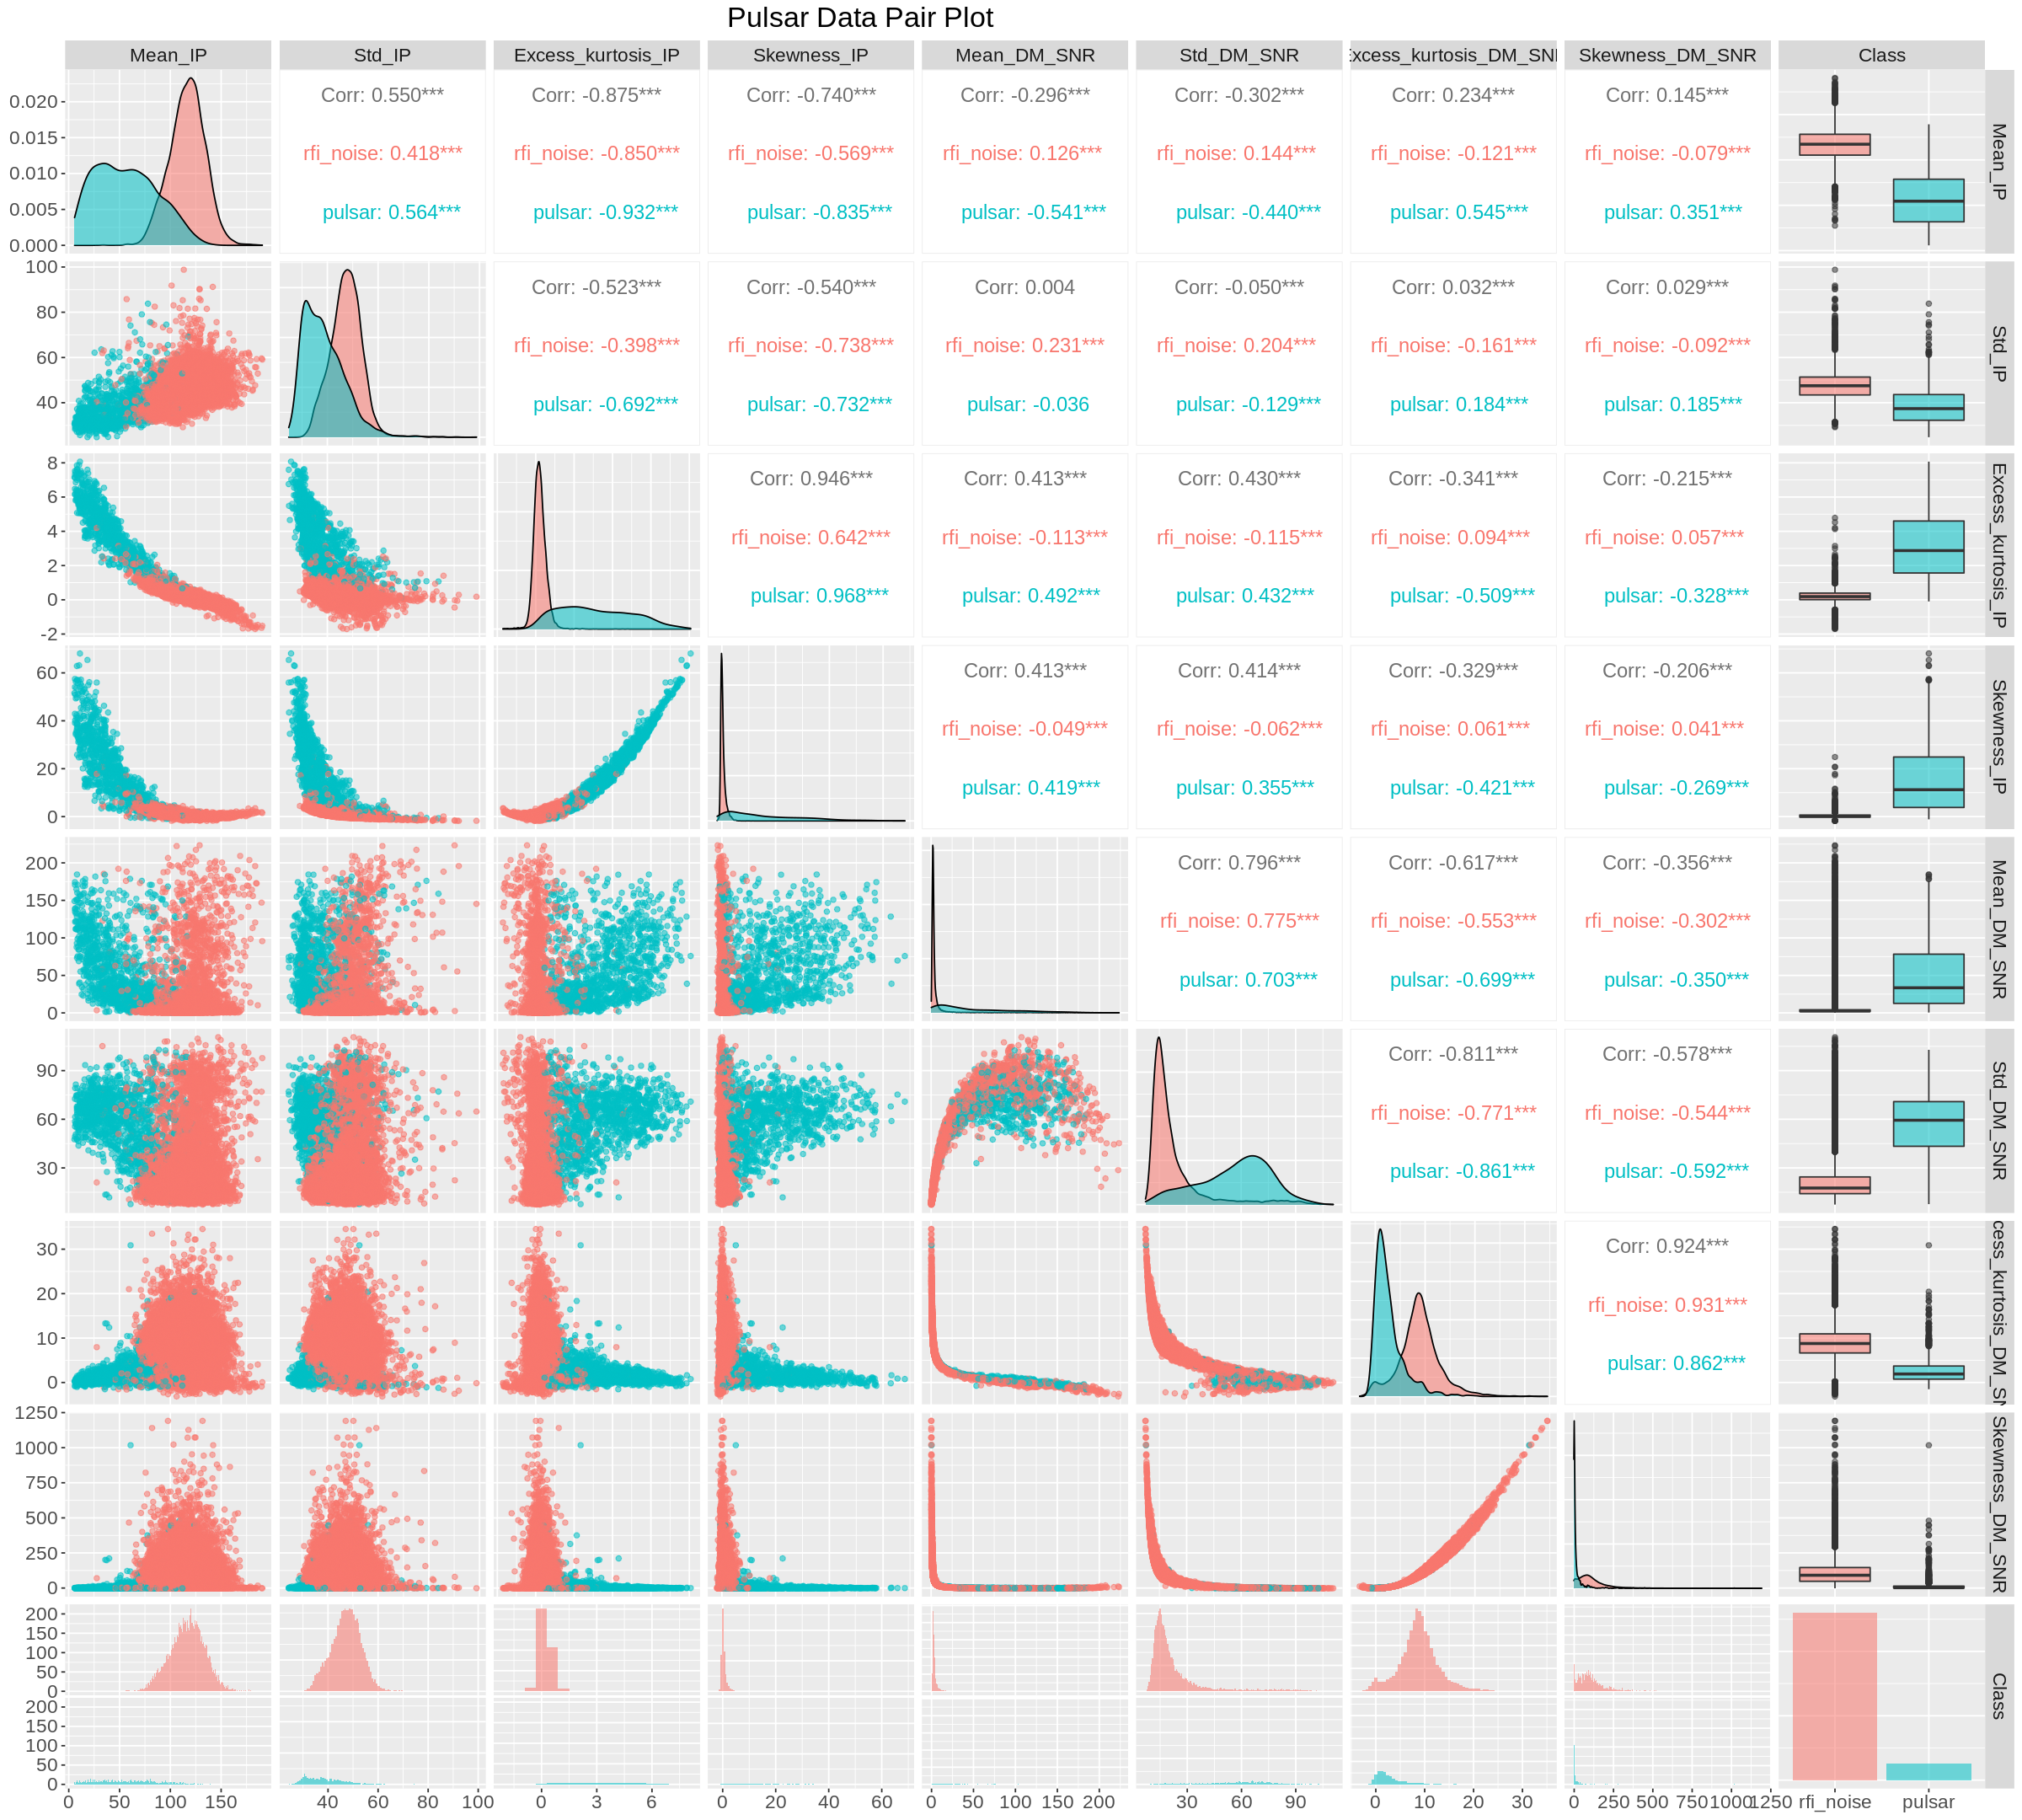

In [6]:
options(repr.plot.width = 20, repr.plot.height = 18)

ggpairs(pulsar_train,
           mapping = aes(color=Class, alpha = 0.3),
           lower=list(combo=wrap("facethist", binwidth=0.6)),
           upper=list(continuous = wrap("cor", size=5))) +
        ggtitle("Pulsar Data Pair Plot") +
        theme(text = element_text(size = 17),
              plot.title = element_text(hjust = 0.4))

## Methods

- This is a classification problem where the response variable is evidently "Class". We plan on using the KNN model for our predictions.
- To conduct data analysis, we first explored and understood the relationships between variables provided by the HTRU2 dataset using data analysis techniques we have learned in class. 
- We used visualization tools (here, pair plots) to identify patterns, trends, and outliers in the data. This will help us figure out the best predictor variables for our classifier. Looking at the plot above, we can see that there is a significant overlap between pulsars and radio noise in many of the given variables. Hence, we may also consider filtering extreme outliers for better training of our classification model. 
- In this case, we will not include "mean_dm_snr", "excess_kurtosis_dm_snr", and "skewness_dm_snr" in our model as these variables do not provide good demarcation of Class when plotted against the other variables. 
- We plan on standardizing the data by centering and scaling it for our recipe.  
- For making a predicting model, we might exclude more variables that don't show high correlation. This will ensure that our classifier is compact, efficient, and easy to understand.
- After pre-processing data and selecting variables, we will begin training the model. 
- After training the model, we will evaluate it using the testing data. We will analyze some of the important features, such as the accuracy of the model.
- Additionally, we will assess the fit of the model to ensure we avoid overfitting or underfitting. 

**Visualizing the results:**
Once we have a fairly accurate classifier to start with, we plan on visualizing our results to evaluate the performance of the classifier. An example of a plot we might use is a confusion matrix plot to show the true positive, true negative, false positive, and false negative values for the classifier's predictions.

## Expected outcomes and significance
We expect to be able to classify a detected signal as either a pulsar star or radio noise using statistical predictors.

**Impact of findings**

Astronomers are using pulsars throughout the Milky Way Galaxy as a giant scientific instrument to directly detect gravitational waves.
Such findings about classification related to pulsars could greatly benefit astronomers in their exploration of space, based on the patterns of radio emissions released by the pulsars. 

**Future questions**

Pulsars can be used to test aspects of general relativity and henceforth question the previous existing theories and understandings of space to enhance our existing knowledge of space.

## Citations

[1] R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, Fifty Years of Pulsar Candidate Selection: From simple filters to a new principled real-time classification approach, Monthly Notices of the Royal Astronomical Society 459 (1), 1104-1123, DOI: 10.1093/mnras/stw656

[2] D. R. Lorimer and M. Kramer, "Handbook of Pulsar Astronomy", Cambridge University Press, 2005.